# Anime CC0 VAE Training
このノートブックでは、リポジトリに含まれている公式PyTorchのVAE実装をベースに、Anime CC0データセット(Dataset: anime-with-caption-cc0 (CC0 1.0))へ適用して訓練・可視化を行います。

## セットアップ
公式実装（`examples/vae/main.py`）からVAEアーキテクチャと損失関数を抽出し、学習に必要なライブラリとパスを定義します。

In [1]:
import ast
import random
from contextlib import nullcontext
from dataclasses import asdict, dataclass, field
from pathlib import Path
from typing import Dict, Literal

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import amp, nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image

plt.style.use('seaborn-v0_8')
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
    torch.cuda.set_device(0)
    DEVICE = torch.device('cuda')
    DEVICE_NAME = torch.cuda.get_device_name(torch.cuda.current_device())
    PIN_MEMORY = True
    NON_BLOCKING = True
    SCALER_DEVICE = 'cuda'
    print(f'Using device: {DEVICE} ({DEVICE_NAME})')
else:
    DEVICE = torch.device('cpu')
    DEVICE_NAME = 'CPU'
    PIN_MEMORY = False
    NON_BLOCKING = False
    SCALER_DEVICE = None
    print('CUDAが利用できません。CPUで実行します。')

AMP_ENABLED = SCALER_DEVICE is not None

def autocast_context():
    return amp.autocast(device_type='cuda') if AMP_ENABLED else nullcontext()

REPO_ROOT = Path('/home/user/vae-paper-to-code').resolve()
script_path = REPO_ROOT / 'examples' / 'vae' / 'main.py'

source = script_path.read_text()
module_ast = ast.parse(source)

vae_node = next(node for node in module_ast.body if isinstance(node, ast.ClassDef) and node.name == 'VAE')
loss_node = next(node for node in module_ast.body if isinstance(node, ast.FunctionDef) and node.name == 'loss_function')

namespace: Dict[str, object] = {}
exec(compile(ast.Module(body=[vae_node], type_ignores=[]), filename=str(script_path), mode='exec'), globals(), namespace)
VAE = namespace['VAE']

namespace = {}
exec(compile(ast.Module(body=[loss_node], type_ignores=[]), filename=str(script_path), mode='exec'), globals(), namespace)
loss_function = namespace['loss_function']



Using device: cuda (NVIDIA GeForce RTX 3070)


## データセットの準備
Anime CC0 の画像をグレースケール28×28へリサイズし、訓練/検証に分割します。

In [2]:
# Configuration definitions moved to the next cell.

In [3]:
@dataclass
class DatasetConfig:
    data_root: Path = Path('~/datasets/anime_cc0/images_train').expanduser()
    image_size: int = 28
    max_samples: int | None = 12000
    val_split: float = 0.1

@dataclass
class LoaderConfig:
    batch_size: int = 256
    num_workers: int = 2
    pin_memory: bool = True
    persistent_workers: bool | None = None

@dataclass
class TrainingConfig:
    epochs: int = 30
    learning_rate: float = 1e-3
    beta: float = 1.0
    grad_clip: float | None = None

@dataclass
class ModelConfig:
    variant: Literal['official_mlp', 'conv'] = 'official_mlp'
    latent_dim: int = 20
    input_channels: int = 1
    hidden_dims: tuple[int, ...] = (32, 64, 128, 256, 512)
    output_activation: Literal['sigmoid', 'tanh'] = 'sigmoid'

@dataclass
class ExperimentConfig:
    dataset: DatasetConfig = field(default_factory=DatasetConfig)
    loader: LoaderConfig = field(default_factory=LoaderConfig)
    training: TrainingConfig = field(default_factory=TrainingConfig)
    model: ModelConfig = field(default_factory=ModelConfig)

    def to_dict(self) -> Dict[str, object]:
        raw = asdict(self)
        def convert(value):
            if isinstance(value, Path):
                return str(value)
            if isinstance(value, dict):
                return {k: convert(v) for k, v in value.items()}
            if isinstance(value, (list, tuple)):
                return [convert(v) for v in value]
            return value
        return convert(raw)

    def loader_kwargs(self, device: torch.device) -> Dict[str, object]:
        kwargs: Dict[str, object] = {
            'batch_size': self.loader.batch_size,
            'num_workers': self.loader.num_workers,
        }
        if device.type != 'cpu' and self.loader.pin_memory:
            kwargs['pin_memory'] = True
        if self.loader.num_workers > 0:
            persistent = self.loader.persistent_workers
            if persistent is None:
                persistent = True
            kwargs['persistent_workers'] = persistent
        return kwargs

PRESET_DESCRIPTIONS = {
    'fast_debug': '小さなサンプル数とエポックで動作確認用に高速実行します。',
    'balanced': '元の公式実装に近い手軽な構成です。',
    'high_quality': '畳み込みVAEと長時間学習で高品質なサンプル生成を狙います。',
}

def make_experiment_config(preset: str = 'balanced') -> ExperimentConfig:
    cfg = ExperimentConfig()
    if preset == 'fast_debug':
        cfg.dataset.max_samples = 512
        cfg.loader.batch_size = 64
        cfg.loader.num_workers = 2
        cfg.training.epochs = 3
        cfg.training.learning_rate = 1e-3
        cfg.training.grad_clip = None
        cfg.model.variant = 'official_mlp'
        cfg.model.latent_dim = 20
    elif preset == 'high_quality':
        cfg.dataset.image_size = 64
        cfg.dataset.max_samples = None
        cfg.loader.batch_size = 256
        cfg.loader.num_workers = 4
        cfg.loader.pin_memory = True
        cfg.loader.persistent_workers = True
        cfg.training.epochs = 80
        cfg.training.learning_rate = 5e-4
        cfg.training.beta = 1.0
        cfg.training.grad_clip = 1.0
        cfg.model.variant = 'conv'
        cfg.model.latent_dim = 96
        cfg.model.input_channels = 1
        cfg.model.hidden_dims = (64, 128, 256, 512)
        cfg.model.output_activation = 'sigmoid'
    else:  # balanced (default)
        cfg.dataset.image_size = 28
        cfg.dataset.max_samples = 12000
        cfg.loader.batch_size = 256
        cfg.loader.num_workers = 2
        cfg.training.epochs = 15
        cfg.training.learning_rate = 1e-3
        cfg.training.beta = 1.0
        cfg.model.variant = 'official_mlp'
        cfg.model.latent_dim = 20
        cfg.model.input_channels = 1
        cfg.model.hidden_dims = (32, 64, 128, 256)

    return cfg

ACTIVE_PRESET = 'high_quality'
print(f"Using preset: {ACTIVE_PRESET} — {PRESET_DESCRIPTIONS[ACTIVE_PRESET]}")
cfg = make_experiment_config(ACTIVE_PRESET)
cfg

Using preset: high_quality — 畳み込みVAEと長時間学習で高品質なサンプル生成を狙います。


ExperimentConfig(dataset=DatasetConfig(data_root=PosixPath('/home/user/datasets/anime_cc0/images_train'), image_size=64, max_samples=None, val_split=0.1), loader=LoaderConfig(batch_size=256, num_workers=4, pin_memory=True, persistent_workers=True), training=TrainingConfig(epochs=80, learning_rate=0.0005, beta=1.0, grad_clip=1.0), model=ModelConfig(variant='conv', latent_dim=96, input_channels=1, hidden_dims=(64, 128, 256, 512), output_activation='sigmoid'))

In [4]:
class AnimeImageDataset(Dataset):
    def __init__(self, root: Path, transform: transforms.Compose | None = None, *, max_samples: int | None = None, seed: int = 0):
        root = Path(root)
        if not root.exists():
            raise FileNotFoundError(f'データディレクトリが見つかりません: {root}')
        paths = [p for p in sorted(root.iterdir()) if p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.webp'}]
        if not paths:
            paths = [p for p in sorted(root.rglob('*')) if p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.webp'}]
        if not paths:
            raise FileNotFoundError(f'指定パス配下に画像ファイルがありません: {root}')
        if max_samples is not None and len(paths) > max_samples:
            rng = random.Random(seed)
            paths = rng.sample(paths, max_samples)
        self.paths = paths
        self.transform = transform

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, index: int) -> torch.Tensor:
        path = self.paths[index]
        with Image.open(path) as img:
            img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img

transform_steps = [
    transforms.Resize((cfg.dataset.image_size, cfg.dataset.image_size)),
]
if cfg.model.input_channels == 1:
    transform_steps.append(transforms.Grayscale(num_output_channels=1))
else:
    transform_steps.append(transforms.Lambda(lambda img: img))
transform_steps.append(transforms.ToTensor())
if cfg.model.output_activation == 'tanh':
    mean = [0.5] * cfg.model.input_channels
    std = [0.5] * cfg.model.input_channels
    transform_steps.append(transforms.Normalize(mean, std))

transform = transforms.Compose(transform_steps)

full_dataset = AnimeImageDataset(cfg.dataset.data_root, transform=transform, max_samples=cfg.dataset.max_samples, seed=SEED)
val_size = max(1, int(len(full_dataset) * cfg.dataset.val_split))
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED),
)

loader_kwargs = cfg.loader_kwargs(DEVICE)
train_loader = DataLoader(train_dataset, shuffle=True, **loader_kwargs)
val_loader = DataLoader(val_dataset, shuffle=False, **loader_kwargs)

len(full_dataset), train_size, val_size

(15000, 13500, 1500)

## 学習
プリセットで選択したモデル（公式MLPまたはカスタム畳み込みVAE）とハイパーパラメーターを用いてfinetuneします。`cfg.training.beta`でKLD係数を調整できます。

In [5]:
class OfficialMLPVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = VAE()

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.model(x)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.model.decode(z)

class ConvVAE(nn.Module):
    def __init__(self, *, image_size: int, in_channels: int, latent_dim: int, hidden_dims: tuple[int, ...], output_activation: str):
        super().__init__()
        if image_size % (2 ** len(hidden_dims)) != 0:
            raise ValueError('image_size must be divisible by 2 ** len(hidden_dims) to use ConvVAE')
        self.image_size = image_size
        self.in_channels = in_channels
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims

        encoder_modules = []
        channels = in_channels
        for hidden in hidden_dims:
            encoder_modules.append(nn.Sequential(
                nn.Conv2d(channels, hidden, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(hidden),
                nn.LeakyReLU(0.2, inplace=True),
            ))
            channels = hidden
        self.encoder = nn.Sequential(*encoder_modules)

        final_spatial = image_size // (2 ** len(hidden_dims))
        self._conv_out_dim = hidden_dims[-1] * final_spatial * final_spatial
        self.fc_mu = nn.Linear(self._conv_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self._conv_out_dim, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, self._conv_out_dim)

        decoder_hidden_dims = list(hidden_dims[::-1])
        decoder_modules = []
        for idx in range(len(decoder_hidden_dims) - 1):
            decoder_modules.append(nn.Sequential(
                nn.ConvTranspose2d(
                    decoder_hidden_dims[idx],
                    decoder_hidden_dims[idx + 1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.BatchNorm2d(decoder_hidden_dims[idx + 1]),
                nn.LeakyReLU(0.2, inplace=True),
            ))
        self.decoder = nn.Sequential(*decoder_modules)

        activation_layer: nn.Module
        if output_activation == 'sigmoid':
            activation_layer = nn.Sigmoid()
        elif output_activation == 'tanh':
            activation_layer = nn.Tanh()
        else:
            raise ValueError(f'Unsupported output activation: {output_activation}')

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                decoder_hidden_dims[-1],
                decoder_hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(decoder_hidden_dims[-1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(decoder_hidden_dims[-1], in_channels, kernel_size=3, padding=1),
            activation_layer,
        )

    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        logvar = self.fc_logvar(result)
        return mu, logvar

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        result = self.decoder_input(z)
        result = result.view(z.size(0), self.hidden_dims[-1], self.image_size // (2 ** len(self.hidden_dims)), self.image_size // (2 ** len(self.hidden_dims)))
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def build_model(cfg: ExperimentConfig) -> nn.Module:
    if cfg.model.variant == 'official_mlp':
        model = OfficialMLPVAE()
    elif cfg.model.variant == 'conv':
        model = ConvVAE(
            image_size=cfg.dataset.image_size,
            in_channels=cfg.model.input_channels,
            latent_dim=cfg.model.latent_dim,
            hidden_dims=cfg.model.hidden_dims,
            output_activation=cfg.model.output_activation,
        )
    else:
        raise ValueError(f'Unknown model variant: {cfg.model.variant}')
    return model

def reconstruction_and_kl_losses(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor, *, beta: float) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    if recon_x.dim() == 2 and x.dim() == 4:
        recon_flat = recon_x
        target_flat = x.view(x.size(0), -1)
    else:
        recon_flat = recon_x.view(recon_x.size(0), -1)
        target_flat = x.view(x.size(0), -1)
    recon_loss = F.binary_cross_entropy(recon_flat, target_flat, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total = recon_loss + beta * kld
    return total, recon_loss, kld


In [6]:
from time import perf_counter


def run_training(cfg: ExperimentConfig):
    model = build_model(cfg).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=cfg.training.learning_rate)
    scaler = amp.GradScaler(device=SCALER_DEVICE) if AMP_ENABLED else None

    history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'train_recon': [],
        'val_recon': [],
        'train_kld': [],
        'val_kld': [],
    }
    best_val_loss = float('inf')
    best_state = None
    best_examples = None

    for epoch in range(1, cfg.training.epochs + 1):
        start = perf_counter()
        model.train()
        train_loss = 0.0
        train_recon = 0.0
        train_kld = 0.0
        for batch in train_loader:
            data = batch.to(DEVICE, non_blocking=NON_BLOCKING)
            optimizer.zero_grad(set_to_none=True)
            with autocast_context():
                recon_batch, mu, logvar = model(data)
            total_loss, recon_loss, kld_loss = reconstruction_and_kl_losses(
                recon_batch.float(),
                data.float(),
                mu.float(),
                logvar.float(),
                beta=cfg.training.beta,
            )
            if scaler is not None:
                scaler.scale(total_loss).backward()
                if cfg.training.grad_clip is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.training.grad_clip)
                scaler.step(optimizer)
                scaler.update()
            else:
                total_loss.backward()
                if cfg.training.grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.training.grad_clip)
                optimizer.step()
            train_loss += total_loss.item()
            train_recon += recon_loss.item()
            train_kld += kld_loss.item()

        train_loss /= len(train_loader.dataset)
        train_recon /= len(train_loader.dataset)
        train_kld /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_recon = 0.0
        val_kld = 0.0
        first_batch = None
        first_recon = None
        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                data = batch.to(DEVICE, non_blocking=NON_BLOCKING)
                with autocast_context():
                    recon_batch, mu, logvar = model(data)
                batch_total, batch_recon, batch_kld = reconstruction_and_kl_losses(
                    recon_batch.float(),
                    data.float(),
                    mu.float(),
                    logvar.float(),
                    beta=cfg.training.beta,
                )
                val_loss += batch_total.item()
                val_recon += batch_recon.item()
                val_kld += batch_kld.item()
                if i == 0:
                    first_batch = data.detach().cpu()
                    first_recon = recon_batch.float().detach().cpu()

        val_loss /= len(val_loader.dataset)
        val_recon /= len(val_loader.dataset)
        val_kld /= len(val_loader.dataset)

        history['epoch'].append(epoch)
        history['train_loss'].append(float(train_loss))
        history['val_loss'].append(float(val_loss))
        history['train_recon'].append(float(train_recon))
        history['val_recon'].append(float(val_recon))
        history['train_kld'].append(float(train_kld))
        history['val_kld'].append(float(val_kld))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_examples = {
                'epoch': epoch,
                'inputs': first_batch.clone(),
                'recons': first_recon.clone(),
            }

        if AMP_ENABLED:
            torch.cuda.synchronize()
        elapsed = perf_counter() - start
        print(
            f"Epoch {epoch:03d} | train={train_loss:.4f} (recon={train_recon:.4f}, kld={train_kld:.4f}) | "
            f"val={val_loss:.4f} (recon={val_recon:.4f}, kld={val_kld:.4f}) | time={elapsed/60:.2f}m"
        )

    model.load_state_dict(best_state)
    return model, history, best_examples


model, history, best_examples = run_training(cfg)
model


Epoch 001 | train=2832.0007 (recon=2804.8887, kld=27.1119) | val=2680.2103 (recon=2621.3938, kld=58.8166) | time=0.26m


Epoch 002 | train=2640.9096 (recon=2585.9763, kld=54.9333) | val=2634.4701 (recon=2570.2340, kld=64.2360) | time=0.24m


Epoch 003 | train=2614.4302 (recon=2551.9419, kld=62.4882) | val=2613.6508 (recon=2544.9805, kld=68.6703) | time=0.24m


Epoch 004 | train=2602.8567 (recon=2536.2828, kld=66.5738) | val=2605.0752 (recon=2536.3473, kld=68.7279) | time=0.25m


Epoch 005 | train=2597.2954 (recon=2527.9614, kld=69.3340) | val=2601.7747 (recon=2530.1644, kld=71.6103) | time=0.27m


Epoch 006 | train=2594.0666 (recon=2523.0103, kld=71.0563) | val=2598.7564 (recon=2524.5515, kld=74.2049) | time=0.27m


Epoch 007 | train=2590.8610 (recon=2518.3236, kld=72.5375) | val=2599.3987 (recon=2526.1684, kld=73.2302) | time=0.26m


Epoch 008 | train=2588.6827 (recon=2514.9851, kld=73.6976) | val=2594.7919 (recon=2518.6994, kld=76.0926) | time=0.25m


Epoch 009 | train=2587.2842 (recon=2512.6744, kld=74.6099) | val=2592.4733 (recon=2517.6296, kld=74.8437) | time=0.26m


Epoch 010 | train=2585.5189 (recon=2510.5412, kld=74.9777) | val=2594.4470 (recon=2519.0833, kld=75.3637) | time=0.25m


Epoch 011 | train=2584.2642 (recon=2508.7277, kld=75.5365) | val=2591.0013 (recon=2515.1078, kld=75.8934) | time=0.25m


Epoch 012 | train=2583.0312 (recon=2507.4215, kld=75.6098) | val=2589.3402 (recon=2512.9894, kld=76.3509) | time=0.25m


Epoch 013 | train=2581.5608 (recon=2505.7090, kld=75.8518) | val=2589.8472 (recon=2512.5337, kld=77.3135) | time=0.25m


Epoch 014 | train=2581.2532 (recon=2505.2104, kld=76.0427) | val=2589.6165 (recon=2516.0620, kld=73.5545) | time=0.25m


Epoch 015 | train=2580.4371 (recon=2504.6142, kld=75.8229) | val=2591.6395 (recon=2510.3868, kld=81.2528) | time=0.25m


Epoch 016 | train=2579.3924 (recon=2503.2127, kld=76.1797) | val=2591.3724 (recon=2511.8088, kld=79.5636) | time=0.25m


Epoch 017 | train=2578.8323 (recon=2502.7626, kld=76.0697) | val=2586.8970 (recon=2509.5687, kld=77.3284) | time=0.25m


Epoch 018 | train=2578.2204 (recon=2502.0642, kld=76.1562) | val=2590.0460 (recon=2513.3727, kld=76.6733) | time=0.25m


Epoch 019 | train=2578.0689 (recon=2501.9648, kld=76.1042) | val=2587.1726 (recon=2511.0579, kld=76.1147) | time=0.25m


Epoch 020 | train=2577.1236 (recon=2500.8565, kld=76.2671) | val=2591.9329 (recon=2515.6312, kld=76.3017) | time=0.25m


Epoch 021 | train=2576.4426 (recon=2500.1865, kld=76.2561) | val=2588.4167 (recon=2512.2840, kld=76.1328) | time=0.25m


Epoch 022 | train=2575.4526 (recon=2498.9664, kld=76.4862) | val=2588.7826 (recon=2511.7525, kld=77.0301) | time=0.25m


Epoch 023 | train=2575.0881 (recon=2498.6479, kld=76.4402) | val=2587.0622 (recon=2509.2134, kld=77.8487) | time=0.25m


Epoch 024 | train=2574.2000 (recon=2497.6364, kld=76.5637) | val=2585.8198 (recon=2509.5891, kld=76.2307) | time=0.25m


Epoch 025 | train=2573.9699 (recon=2497.4829, kld=76.4870) | val=2587.3886 (recon=2509.1468, kld=78.2418) | time=0.25m


Epoch 026 | train=2573.8387 (recon=2497.2200, kld=76.6187) | val=2587.3127 (recon=2512.5583, kld=74.7544) | time=0.25m


Epoch 027 | train=2572.9472 (recon=2496.1765, kld=76.7707) | val=2588.3296 (recon=2511.6500, kld=76.6796) | time=0.25m


Epoch 028 | train=2572.5953 (recon=2495.8129, kld=76.7824) | val=2587.5900 (recon=2512.3452, kld=75.2447) | time=0.25m


Epoch 029 | train=2571.8215 (recon=2495.2499, kld=76.5716) | val=2586.2869 (recon=2508.2526, kld=78.0343) | time=0.25m


Epoch 030 | train=2572.0739 (recon=2495.2032, kld=76.8708) | val=2587.7756 (recon=2509.5819, kld=78.1938) | time=0.25m


Epoch 031 | train=2571.2222 (recon=2494.1233, kld=77.0988) | val=2587.5127 (recon=2510.0417, kld=77.4710) | time=0.25m


Epoch 032 | train=2571.2395 (recon=2494.1505, kld=77.0891) | val=2586.8432 (recon=2509.6956, kld=77.1476) | time=0.27m


Epoch 033 | train=2570.8509 (recon=2493.8155, kld=77.0355) | val=2588.6238 (recon=2512.7527, kld=75.8711) | time=0.28m


Epoch 034 | train=2570.2199 (recon=2492.9757, kld=77.2442) | val=2587.0744 (recon=2510.2040, kld=76.8704) | time=0.28m


Epoch 035 | train=2569.4022 (recon=2492.1068, kld=77.2954) | val=2587.9007 (recon=2511.6021, kld=76.2986) | time=0.26m


Epoch 036 | train=2569.6214 (recon=2492.4939, kld=77.1275) | val=2586.5497 (recon=2509.0524, kld=77.4973) | time=0.26m


Epoch 037 | train=2568.0570 (recon=2490.5357, kld=77.5214) | val=2588.1486 (recon=2512.2658, kld=75.8829) | time=0.27m


Epoch 038 | train=2569.0341 (recon=2491.5671, kld=77.4670) | val=2587.5877 (recon=2508.5579, kld=79.0297) | time=0.27m


Epoch 039 | train=2568.3285 (recon=2490.6372, kld=77.6913) | val=2586.7068 (recon=2510.2827, kld=76.4241) | time=0.25m


Epoch 040 | train=2567.3899 (recon=2489.7146, kld=77.6754) | val=2587.5642 (recon=2510.2663, kld=77.2979) | time=0.26m


Epoch 041 | train=2567.5671 (recon=2489.8796, kld=77.6875) | val=2587.7285 (recon=2512.0307, kld=75.6978) | time=0.26m


Epoch 042 | train=2566.4780 (recon=2488.5889, kld=77.8892) | val=2587.4730 (recon=2509.0228, kld=78.4503) | time=0.27m


Epoch 043 | train=2566.2707 (recon=2488.4154, kld=77.8553) | val=2587.6217 (recon=2509.2898, kld=78.3320) | time=0.27m


Epoch 044 | train=2565.8872 (recon=2487.9774, kld=77.9097) | val=2589.2941 (recon=2510.0701, kld=79.2240) | time=0.26m


Epoch 045 | train=2565.7058 (recon=2487.6126, kld=78.0932) | val=2588.3826 (recon=2510.2294, kld=78.1533) | time=0.28m


Epoch 046 | train=2565.4233 (recon=2487.1394, kld=78.2840) | val=2587.9870 (recon=2511.3943, kld=76.5927) | time=0.28m


Epoch 047 | train=2565.5092 (recon=2487.4182, kld=78.0911) | val=2588.4840 (recon=2507.6803, kld=80.8038) | time=0.26m


Epoch 048 | train=2564.4473 (recon=2486.1194, kld=78.3279) | val=2590.1562 (recon=2514.4737, kld=75.6824) | time=0.26m


Epoch 049 | train=2563.8454 (recon=2485.1815, kld=78.6638) | val=2588.4553 (recon=2511.2058, kld=77.2495) | time=0.26m


Epoch 050 | train=2564.0813 (recon=2485.3468, kld=78.7345) | val=2589.3782 (recon=2511.7635, kld=77.6146) | time=0.26m


Epoch 051 | train=2563.3972 (recon=2484.8637, kld=78.5335) | val=2589.1523 (recon=2511.3506, kld=77.8017) | time=0.26m


Epoch 052 | train=2563.3676 (recon=2484.7662, kld=78.6014) | val=2591.0164 (recon=2511.7698, kld=79.2467) | time=0.26m


Epoch 053 | train=2562.9556 (recon=2484.1496, kld=78.8060) | val=2589.1345 (recon=2510.0649, kld=79.0697) | time=0.25m


Epoch 054 | train=2562.4110 (recon=2483.5210, kld=78.8900) | val=2589.8861 (recon=2509.0479, kld=80.8382) | time=0.26m


Epoch 055 | train=2562.2802 (recon=2483.4684, kld=78.8118) | val=2590.2690 (recon=2510.8934, kld=79.3756) | time=0.26m


Epoch 056 | train=2562.4513 (recon=2483.2393, kld=79.2120) | val=2591.8292 (recon=2512.3833, kld=79.4459) | time=0.26m


Epoch 057 | train=2561.5939 (recon=2482.5940, kld=78.9999) | val=2590.1951 (recon=2513.2316, kld=76.9635) | time=0.27m


Epoch 058 | train=2560.7683 (recon=2481.5943, kld=79.1739) | val=2592.3778 (recon=2513.5290, kld=78.8488) | time=0.26m


Epoch 059 | train=2560.3185 (recon=2481.1291, kld=79.1894) | val=2590.8457 (recon=2509.3641, kld=81.4815) | time=0.26m


Epoch 060 | train=2560.4982 (recon=2481.1726, kld=79.3256) | val=2590.3291 (recon=2512.5120, kld=77.8171) | time=0.27m


Epoch 061 | train=2559.5752 (recon=2480.2184, kld=79.3568) | val=2589.6605 (recon=2510.2197, kld=79.4408) | time=0.29m


Epoch 062 | train=2559.2530 (recon=2479.8591, kld=79.3938) | val=2590.9176 (recon=2511.0770, kld=79.8406) | time=0.28m


Epoch 063 | train=2559.5679 (recon=2480.0236, kld=79.5442) | val=2592.5879 (recon=2513.7466, kld=78.8413) | time=0.26m


Epoch 064 | train=2558.7796 (recon=2479.3342, kld=79.4454) | val=2590.9080 (recon=2511.6155, kld=79.2925) | time=0.26m


Epoch 065 | train=2559.0431 (recon=2479.2822, kld=79.7609) | val=2591.6335 (recon=2511.7367, kld=79.8969) | time=0.25m


Epoch 066 | train=2558.4525 (recon=2478.5012, kld=79.9513) | val=2592.1723 (recon=2515.1787, kld=76.9936) | time=0.26m


Epoch 067 | train=2558.6216 (recon=2478.7525, kld=79.8691) | val=2592.1663 (recon=2513.5399, kld=78.6264) | time=0.26m


Epoch 068 | train=2558.3981 (recon=2478.4692, kld=79.9289) | val=2591.9630 (recon=2512.2802, kld=79.6828) | time=0.27m


Epoch 069 | train=2558.0152 (recon=2478.1443, kld=79.8709) | val=2590.6811 (recon=2511.8463, kld=78.8348) | time=0.27m


Epoch 070 | train=2557.0648 (recon=2476.9491, kld=80.1157) | val=2591.7875 (recon=2514.1389, kld=77.6486) | time=0.28m


Epoch 071 | train=2557.0789 (recon=2476.8421, kld=80.2368) | val=2592.2805 (recon=2512.5081, kld=79.7724) | time=0.27m


Epoch 072 | train=2556.9465 (recon=2476.7753, kld=80.1712) | val=2592.3373 (recon=2512.0103, kld=80.3270) | time=0.26m


Epoch 073 | train=2557.0890 (recon=2476.7597, kld=80.3293) | val=2591.3864 (recon=2512.4383, kld=78.9481) | time=0.26m


Epoch 074 | train=2556.6750 (recon=2476.3835, kld=80.2916) | val=2592.6610 (recon=2512.6730, kld=79.9881) | time=0.25m


Epoch 075 | train=2556.6698 (recon=2476.2837, kld=80.3861) | val=2592.5506 (recon=2512.8102, kld=79.7403) | time=0.26m


Epoch 076 | train=2555.9288 (recon=2475.1704, kld=80.7584) | val=2592.1719 (recon=2511.6278, kld=80.5441) | time=0.25m


Epoch 077 | train=2556.2019 (recon=2475.5147, kld=80.6873) | val=2593.8996 (recon=2512.9264, kld=80.9732) | time=0.26m


Epoch 078 | train=2555.6251 (recon=2475.1767, kld=80.4484) | val=2592.0122 (recon=2512.6460, kld=79.3663) | time=0.25m


Epoch 079 | train=2555.1899 (recon=2474.7134, kld=80.4765) | val=2593.2888 (recon=2513.1057, kld=80.1831) | time=0.25m


Epoch 080 | train=2555.0644 (recon=2474.3458, kld=80.7186) | val=2593.0193 (recon=2512.9055, kld=80.1138) | time=0.26m


ConvVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU

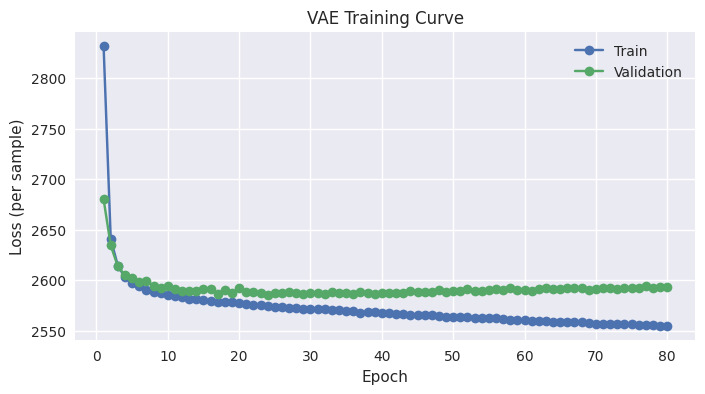

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(history['epoch'], history['train_loss'], marker='o', label='Train')
plt.plot(history['epoch'], history['val_loss'], marker='o', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (per sample)')
plt.title('VAE Training Curve')
plt.legend()
plt.grid(True)
plt.show()

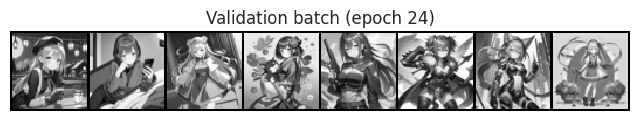

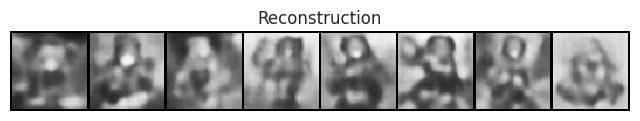

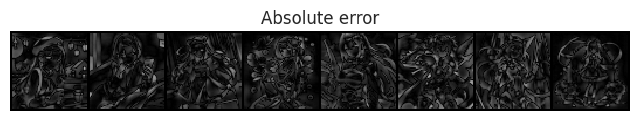

In [8]:
def show_grid(tensors: torch.Tensor, title: str, nrow: int = 8):
    tensors = tensors.detach().cpu()
    grid = make_grid(tensors[:nrow], nrow=nrow, padding=2)
    array = grid.permute(1, 2, 0).numpy()
    if array.shape[2] == 1:
        array = array[:, :, 0]
        plt.imshow(array, cmap='gray', interpolation='nearest')
    else:
        plt.imshow(array, interpolation='nearest')
    plt.axis('off')
    plt.title(title)
    plt.show()

originals = best_examples['inputs']
recons = best_examples['recons'].view(-1, 1, cfg.dataset.image_size, cfg.dataset.image_size)
errors = (originals - recons).abs()

show_grid(originals, f'Validation batch (epoch {best_examples["epoch"]})')
show_grid(recons, 'Reconstruction')
show_grid(errors, 'Absolute error')

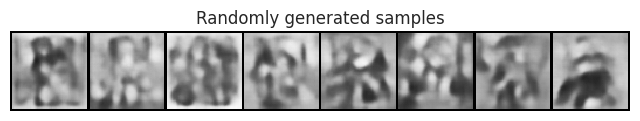

In [9]:
model.eval()
with torch.no_grad():
    noise = torch.randn(64, cfg.model.latent_dim, device=DEVICE)
    samples = model.decode(noise)
    samples = samples.view(-1, cfg.model.input_channels, cfg.dataset.image_size, cfg.dataset.image_size).cpu()
show_grid(samples, 'Randomly generated samples')

## モデルの保存
学習済みパラメータと履歴を `trained_models/` 以下へ保存します。

In [10]:
import json
from datetime import datetime

MODEL_DIR = REPO_ROOT / 'trained_models'
MODEL_DIR.mkdir(exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
model_path = MODEL_DIR / f'anime_cc0_vae_{timestamp}.pt'
history_path = MODEL_DIR / f'anime_cc0_vae_history_{timestamp}.json'

cfg_dict = cfg.to_dict()

torch.save({
    'model_state': model.state_dict(),
    'config': cfg_dict,
    'history': history,
    'best_epoch': int(best_examples['epoch']),
}, model_path)

with history_path.open('w') as f:
    json.dump({
        'config': cfg_dict,
        'history': history,
        'best_epoch': int(best_examples['epoch']),
        'device': str(DEVICE),
    }, f, indent=2, ensure_ascii=False)

model_path, history_path

(PosixPath('/home/user/vae-paper-to-code/trained_models/anime_cc0_vae_20251005-135126.pt'),
 PosixPath('/home/user/vae-paper-to-code/trained_models/anime_cc0_vae_history_20251005-135126.json'))